# Generate tedana walkthrough figures

This notebook generates figures used in tedana's detailed workflow documentation.

What was run:

```bash
prefix=sub-pilot_task-checkerboard
tedana -d \
    /Users/taylor/Documents/datasets/logans-dset/sub-pilot/func/${prefix}_echo-1_bold.nii.gz \
    /Users/taylor/Documents/datasets/logans-dset/sub-pilot/func/${prefix}_echo-2_bold.nii.gz \
    /Users/taylor/Documents/datasets/logans-dset/sub-pilot/func/${prefix}_echo-3_bold.nii.gz \
    /Users/taylor/Documents/datasets/logans-dset/sub-pilot/func/${prefix}_echo-4_bold.nii.gz \
    /Users/taylor/Documents/datasets/logans-dset/sub-pilot/func/${prefix}_echo-5_bold.nii.gz \
    /Users/taylor/Documents/datasets/logans-dset/sub-pilot/func/${prefix}_echo-6_bold.nii.gz \
    /Users/taylor/Documents/datasets/logans-dset/sub-pilot/func/${prefix}_echo-7_bold.nii.gz \
    /Users/taylor/Documents/datasets/logans-dset/sub-pilot/func/${prefix}_echo-8_bold.nii.gz \
    -e 9.58 21.95 34.32 46.69 59.06 71.43 83.8 96.17 \
    --out-dir /Users/taylor/Documents/datasets/logans-dset/tedana-${prefix} \
    --prefix ${prefix} \
    --masktype decay dropout \
    --fittype curvefit \
    --gscontrol gsr mir \
    --tedpca kundu \
    --tedort \
    --verbose \
    --overwrite \
    --tree tedana_orig
```

In [1]:
%matplotlib inline
import os.path as op
from glob import glob

import matplotlib.pyplot as plt
import nibabel as nb
import numpy as np
import pandas as pd
import seaborn as sns
from nilearn import image, masking, plotting

from tedana.io import load_data, new_nii_like
from tedana.utils import make_adaptive_mask

In [2]:
# Load data
DATA_DIR = '/Users/taylor/Documents/datasets/logans-dset/sub-pilot/func/'
TED_DIR = '/Users/taylor/Documents/datasets/logans-dset/tedana-sub-pilot_task-checkerboard'
OUT_DIR = '../_static/'
FILES = [
    'sub-pilot_task-checkerboard_echo-1_bold.nii.gz',
    'sub-pilot_task-checkerboard_echo-2_bold.nii.gz',
    'sub-pilot_task-checkerboard_echo-3_bold.nii.gz',
    'sub-pilot_task-checkerboard_echo-4_bold.nii.gz',
    'sub-pilot_task-checkerboard_echo-5_bold.nii.gz',
    'sub-pilot_task-checkerboard_echo-6_bold.nii.gz',
    'sub-pilot_task-checkerboard_echo-7_bold.nii.gz',
    'sub-pilot_task-checkerboard_echo-8_bold.nii.gz',
]
files = [op.join(DATA_DIR, f) for f in FILES]
echo_times = np.array([9.58, 21.95, 34.32, 46.69, 59.06, 71.43, 83.8, 96.17])

adaptive_mask_file = op.join(TED_DIR, 'sub-pilot_task-checkerboard_desc-adaptiveGoodSignal_mask.nii.gz')
mask = image.math_img('img >= 3', img=adaptive_mask_file)

# Global signal
global_signal = pd.read_table(op.join(TED_DIR, "sub-pilot_task-checkerboard_desc-confounds_timeseries.tsv"))

# Optimally combined data
oc = masking.apply_mask(op.join(TED_DIR, 'sub-pilot_task-checkerboard_desc-optcom_bold.nii.gz'), mask)
oc_z = (oc - np.mean(oc, axis=0)) / np.std(oc, axis=0)

# Results from MEPCA
mepca_mmix = pd.read_table(op.join(TED_DIR, 'sub-pilot_task-checkerboard_desc-PCA_mixing.tsv'))
oc_red = masking.apply_mask(op.join(TED_DIR, 'sub-pilot_task-checkerboard_desc-optcom_whitened_bold.nii.gz'), mask)

# Results from MEICA
meica_mmix = pd.read_table(op.join(TED_DIR, 'sub-pilot_task-checkerboard_desc-ICA_mixing.tsv'))
norm_weights = masking.apply_mask(op.join(TED_DIR, 'sub-pilot_task-checkerboard_desc-ICAAveragingWeights_components.nii.gz'), mask)
meica_beta_files = sorted(glob(op.join(TED_DIR, 'sub-pilot_task-checkerboard_echo-*_desc-ICA_components.nii.gz')))
meica_betas = [masking.apply_mask(f, mask) for f in meica_beta_files]
meica_betas = np.stack(meica_betas, axis=1)
r2_pred_beta_files = sorted(glob(op.join(TED_DIR, 'sub-pilot_task-checkerboard_echo-*_desc-ICAT2ModelPredictions_components.nii.gz')))
r2_pred_betas = [masking.apply_mask(f, mask) for f in r2_pred_beta_files]
r2_pred_betas = np.stack(r2_pred_betas, axis=1)
s0_pred_beta_files = sorted(glob(op.join(TED_DIR, 'sub-pilot_task-checkerboard_echo-*_desc-ICAS0ModelPredictions_components.nii.gz')))
s0_pred_betas = [masking.apply_mask(f, mask) for f in s0_pred_beta_files]
s0_pred_betas = np.stack(s0_pred_betas, axis=1)
meica_kappas = masking.apply_mask(op.join(TED_DIR, 'sub-pilot_task-checkerboard_desc-ICAT2_stat-F_statmap.nii.gz'), mask)
meica_rhos = masking.apply_mask(op.join(TED_DIR, 'sub-pilot_task-checkerboard_desc-ICAS0_stat-F_statmap.nii.gz'), mask)

# Component betas
betas_file = op.join(TED_DIR, 'sub-pilot_task-checkerboard_desc-ICA_components.nii.gz')
beta_maps = masking.apply_mask(betas_file, mask)

# Multi-echo denoised data
dn_data = masking.apply_mask(op.join(TED_DIR, 'sub-pilot_task-checkerboard_desc-denoised_bold.nii.gz'), mask)
hk_data = masking.apply_mask(op.join(TED_DIR, 'sub-pilot_task-checkerboard_desc-optcomAccepted_bold.nii.gz'), mask)

# Post-processed data
dn_t1c_data = masking.apply_mask(op.join(TED_DIR, 'sub-pilot_task-checkerboard_desc-optcomMIRDenoised_bold.nii.gz'), mask)
hk_t1c_data = masking.apply_mask(op.join(TED_DIR, 'sub-pilot_task-checkerboard_desc-optcomAcceptedMIRDenoised_bold.nii.gz'), mask)

# Get voxel index for most related to checkerboard component (found from viewing report)
checkerboard_component = np.abs(beta_maps[99, :])
voxel_idx = np.abs(checkerboard_component - np.percentile(checkerboard_component, q=99.6)).argmin()

# load data
data = [masking.apply_mask(f, mask) for f in files]
ts = [d[:, voxel_idx] for d in data]
ts_1d = np.hstack(ts)

n_echoes = len(data)
n_trs = data[0].shape[0]

# Component table
df = pd.read_table(op.join(TED_DIR, 'sub-pilot_task-checkerboard_desc-tedana_metrics.tsv'))
pal = sns.color_palette('cubehelix', n_echoes)

In [3]:
# Prepare data for model
log_data = np.log(np.abs(ts_1d) + 1)
# log_data = np.log(ts_1d)  # in a perfect world...
x = np.column_stack([np.ones(n_echoes), -1 * echo_times])
X = np.repeat(x, n_trs, axis=0)  # T * E

# Model fit
betas = np.linalg.lstsq(X, log_data, rcond=None)[0]
s0 = np.exp(betas[0])
r2s = betas[1]
t2s = 1. / r2s

# Values for plots
# Values from log-linear model
log_x = np.arange(-1000, 0, .01)
log_y = betas[0] + log_x*betas[1]

# Values from monoexponential decay model
mono_x = np.arange(0, 1000, .01)
mono_y = np.exp(-1*betas[1]*mono_x) * s0

# Get weights for optimal combination
alpha = echo_times * np.exp(-echo_times / t2s)
alpha = alpha / np.sum(alpha)  # unnecessary but good for bar plot below

# Combine data across echoes
oc_manual = np.average(np.vstack(ts), axis=0, weights=alpha)

## Echo-specific timeseries

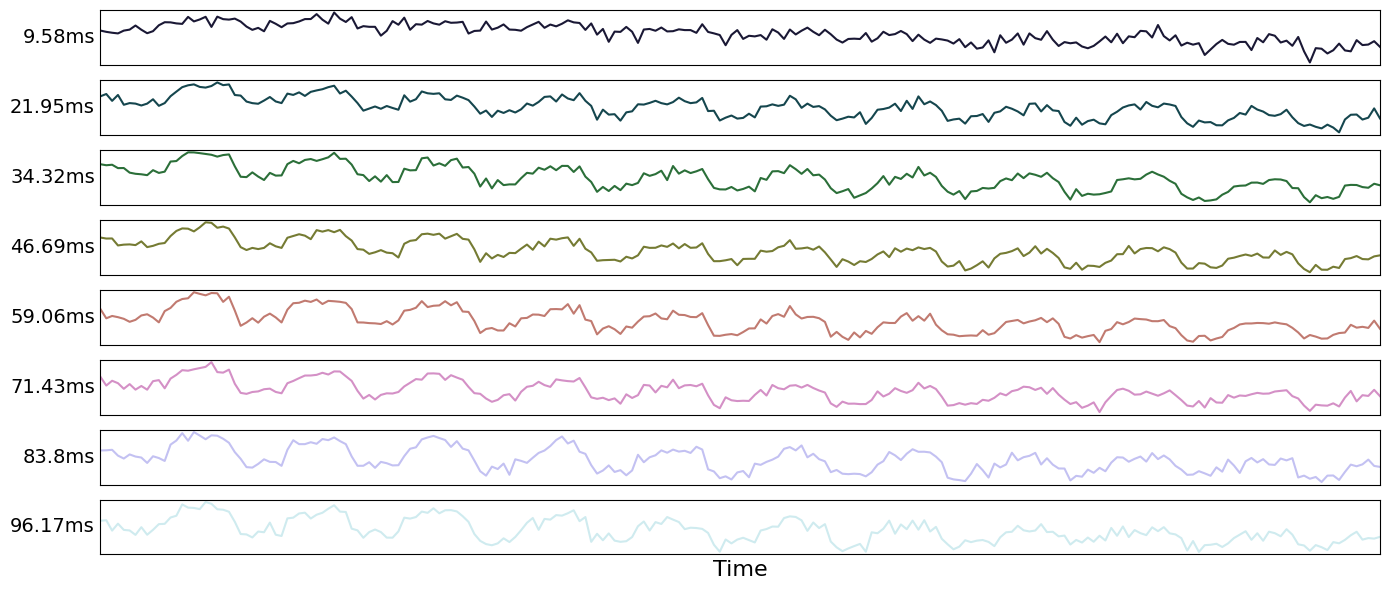

In [4]:
fig, axes = plt.subplots(n_echoes, sharex=True, sharey=False, figsize=(14, 6))
for i_echo in range(n_echoes):
    axes[i_echo].plot(ts[i_echo], color=pal[i_echo])
    axes[i_echo].set_ylabel(f'{echo_times[i_echo]}ms', rotation=0, va='center', ha='right', fontsize=14)
    axes[i_echo].set_yticks([])
    axes[i_echo].set_xticks([])

axes[-1].set_xlabel('Time', fontsize=16)
axes[-1].set_xlim(0, len(ts[i_echo])-1)
fig.tight_layout()
fig.savefig(op.join(OUT_DIR, 'a01_echo_timeseries.png'), dpi=400)

## Echo-specific data and echo time

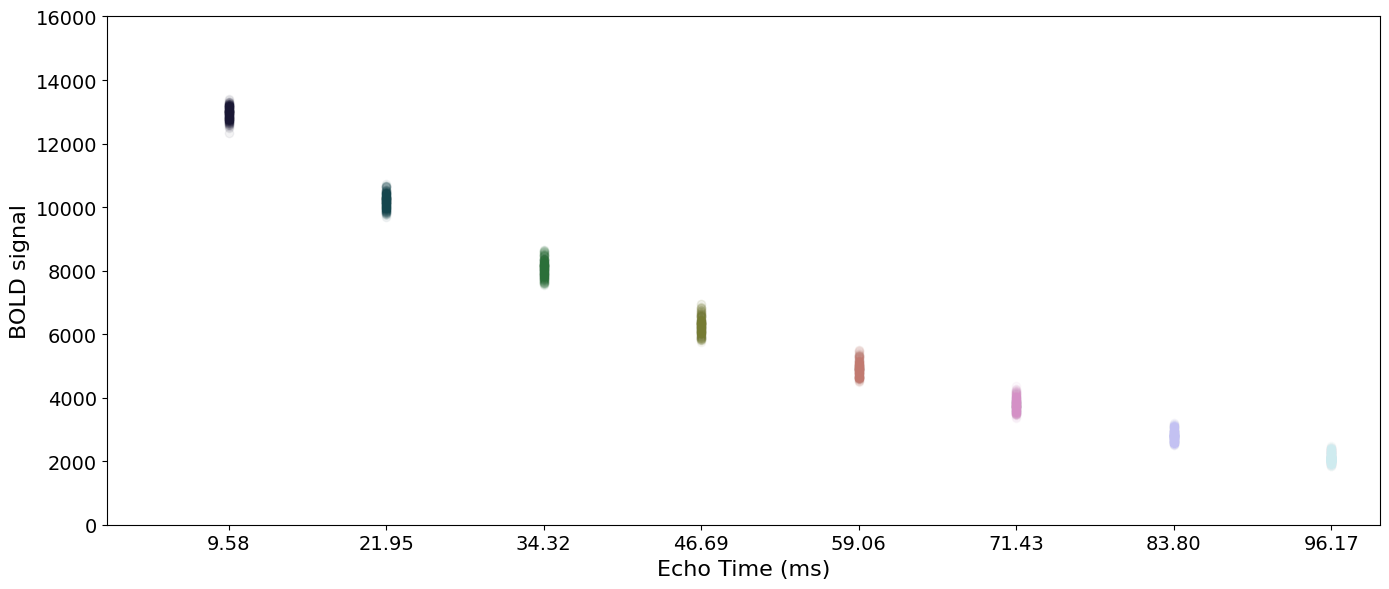

In [5]:
fig, ax = plt.subplots(figsize=(14, 6))
values = [i[0] for i in ts]
for i_echo in range(n_echoes):
    rep_echo_times = np.ones(n_trs) * echo_times[i_echo]
    ax.scatter(rep_echo_times, ts[i_echo], alpha=0.05, color=pal[i_echo])

ax.set_ylabel('BOLD signal', fontsize=16)
ax.set_xlabel('Echo Time (ms)', fontsize=16)
ax.set_xticks(echo_times)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlim(0, 100)
ax.set_ylim(0, 16000)
fig.tight_layout()
fig.savefig(op.join(OUT_DIR, 'a02_echo_value_distributions.png'), dpi=400)

## Adaptive mask
Longer echo times are more susceptible to signal dropout, which means that certain brain regions (e.g., orbitofrontal cortex, temporal poles) will only have good signal for some echoes. In order to avoid using bad signal from affected echoes in calculating $T_{2}^*$ and $S_{0}$ for a given voxel, `tedana` generates an adaptive mask, where the value for each voxel is the number of echoes with "good" signal. When $T_{2}^*$ and $S_{0}$ are calculated below, each voxel's values are only calculated from the first $n$ echoes, where $n$ is the value for that voxel in the adaptive mask.

/opt/miniconda3/envs/salo/lib/python3.9/site-packages/nilearn/image/resampling.py:809: UserWarning: Casting data from int32 to float32
  return resample_img(


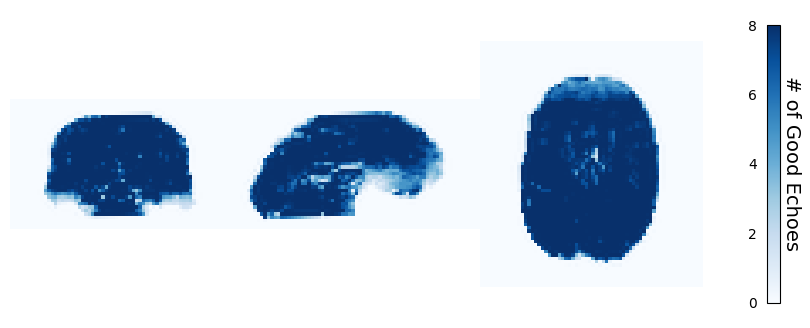

In [6]:
fig, ax = plt.subplots(figsize=(10, 4))
palette = sns.color_palette("BuGn_r", 10)
plt_obj = plotting.plot_epi(
    adaptive_mask_file,
    vmax=8,
    alpha=1,
    draw_cross=False,
    colorbar=True,
    cmap='Blues',
    black_bg=False,
    annotate=False,
    bg_img=None,
    figure=fig,
    axes=ax,
)
temp_ax = fig.axes[-1]
temp_ax.set_ylabel("# of Good Echoes", rotation=270, labelpad=15, fontsize=14)
fig.savefig(op.join(OUT_DIR, 'a03_adaptive_mask.png'), dpi=400)

In [7]:
imgs = [nb.load(f) for f in files]
xyz = np.array([42, 60, 6])
ijk = nb.affines.apply_affine(np.linalg.inv(imgs[0].affine), xyz).astype(int)
i, j, k = ijk
ts_dropout = [img.get_fdata()[i, j, k, :] for img in imgs]
ts_dropout_1d = np.hstack(ts_dropout)

adaptive_mask_img = nb.load(adaptive_mask_file)
adaptive_mask_val = int(adaptive_mask_img.get_fdata()[i, j, k])
adaptive_mask_boundary = np.mean(echo_times[adaptive_mask_val - 1:adaptive_mask_val + 1])

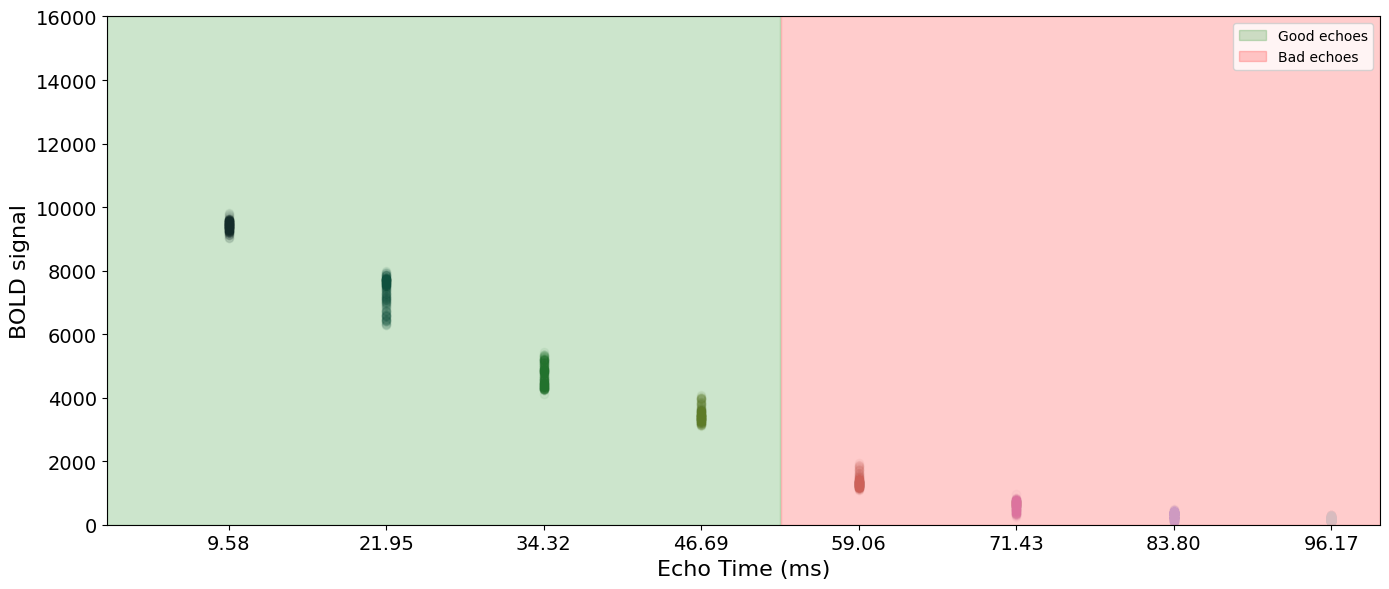

In [8]:
fig, ax = plt.subplots(figsize=(14, 6))
values = [i[0] for i in ts_dropout]
for i_echo in range(n_echoes):
    rep_echo_times = np.ones(n_trs) * echo_times[i_echo]
    ax.scatter(rep_echo_times, ts_dropout[i_echo], alpha=0.05, color=pal[i_echo])

ax.set_ylabel('BOLD signal', fontsize=16)
ax.set_xlabel('Echo Time (ms)', fontsize=16)
ax.set_xticks(echo_times)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlim(0, 100)
ax.set_ylim(0, 16000)
ax.axvspan(0, adaptive_mask_boundary, alpha=0.2, color="green", label="Good echoes")
ax.axvspan(adaptive_mask_boundary + 0.1, 100, alpha=0.2, color="red", label="Bad echoes")
ax.legend()
fig.tight_layout()
fig.savefig(op.join(OUT_DIR, 'a03a_adaptive_mask_distributions.png'), dpi=400)

## Log-linear transformation

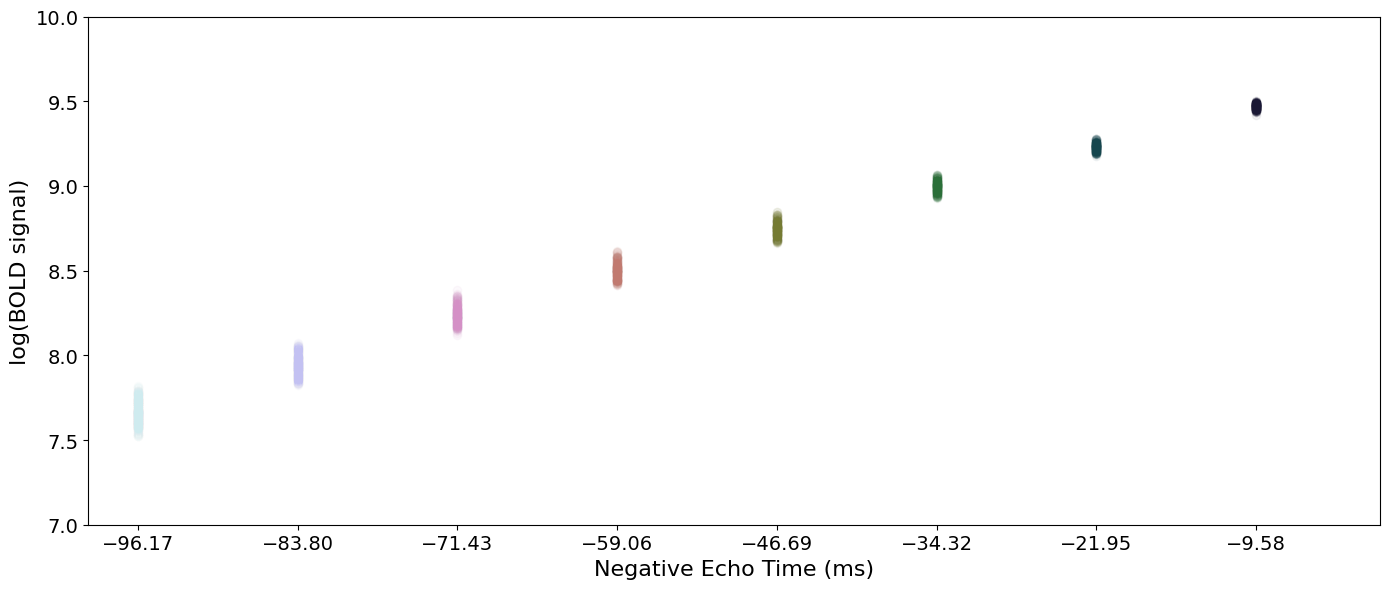

In [9]:
fig, ax = plt.subplots(figsize=(14, 6))
for i_echo in range(n_echoes):
    rep_echo_times = -1 * np.ones(n_trs) * echo_times[i_echo]
    log_echo_data = np.log((np.abs(ts[i_echo]) + 1))
    ax.scatter(rep_echo_times, log_echo_data, alpha=0.05, color=pal[i_echo])

ax.set_ylabel('log(BOLD signal)', fontsize=16)
ax.set_xlabel('Negative Echo Time (ms)', fontsize=16)
ax.set_xticks(-1 * echo_times)
ax.set_xlim(-100, 0)
ax.set_ylim(7, 10)
ax.tick_params(axis='both', which='major', labelsize=14)

fig.tight_layout()
fig.savefig(op.join(OUT_DIR, 'a04_echo_log_value_distributions.png'), dpi=400)

## Log-linear model

Let $S$ be the BOLD signal for a given echo.

Let $TE$ be the echo time in milliseconds.

$$\log_{e}(\left|\begin{pmatrix}
S(TE_{1}) \\
S(TE_{2}) \\
\vdots \\
S(TE_{n})\end{pmatrix}\right|
+
\begin{pmatrix}
1 \\
1 \\
\vdots \\
1\end{pmatrix}
) = B_{1}
\begin{pmatrix}
-TE_{1} \\
-TE_{2} \\
\vdots \\
-TE_{n}\end{pmatrix} + 
\begin{pmatrix}
B_{0} \\
B_{0} \\
\vdots \\
B_{0}\end{pmatrix}$$

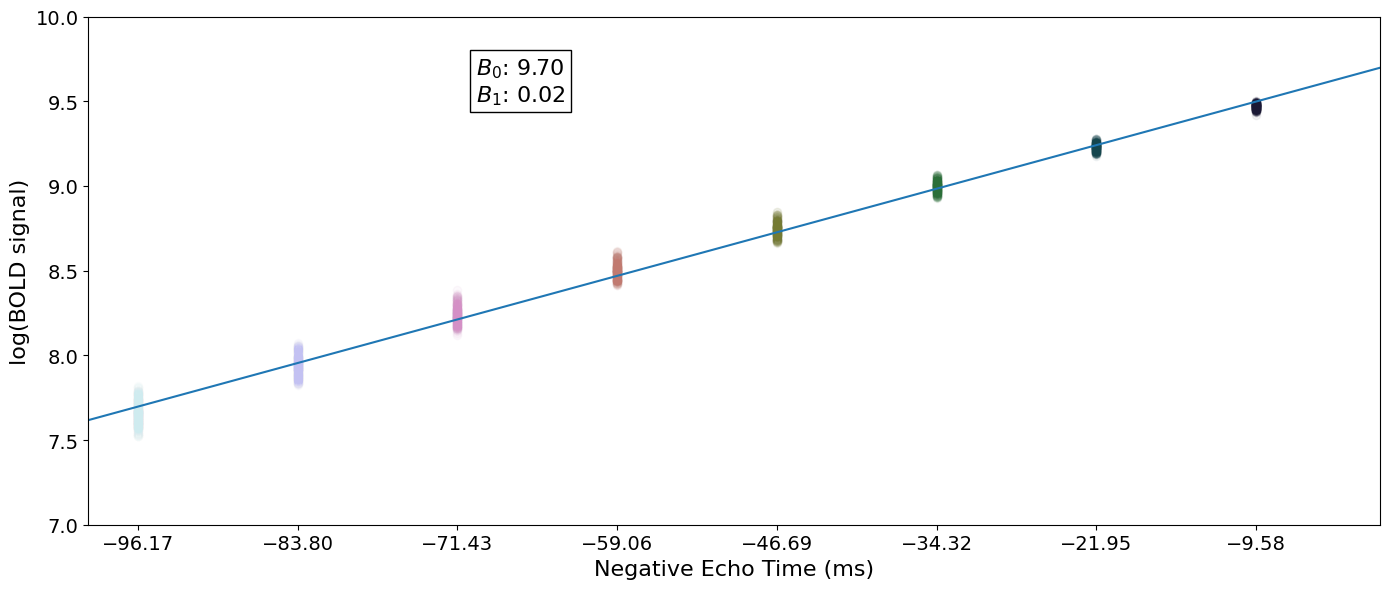

In [10]:
fig, ax = plt.subplots(figsize=(14, 6))
for i_echo in range(n_echoes):
    rep_echo_times = -1 * np.ones(n_trs) * echo_times[i_echo]
    log_echo_data = np.log((np.abs(ts[i_echo]) + 1))
    ax.scatter(rep_echo_times, log_echo_data, alpha=0.05, color=pal[i_echo])

ax.plot(log_x, log_y)

ax.set_ylabel('log(BOLD signal)', fontsize=16)
ax.set_xlabel('Negative Echo Time (ms)', fontsize=16)
ax.set_xticks(-1 * echo_times)
ax.set_xlim(-100, 0)
ax.set_ylim(7, 10)
ax.tick_params(axis='both', which='major', labelsize=14)

ax.annotate('$B_0$: {0:.02f}\n$B_1$: {1:.02f}'.format(betas[0], betas[1]),
            xy=(-70, 9.5), fontsize=16,
            bbox=dict(fc="white", ec="black", lw=1))

fig.tight_layout()
fig.savefig(op.join(OUT_DIR, 'a05_loglinear_regression.png'), dpi=400)

# Monoexponential decay model
Calculation of $S_{0}$ and $T_{2}^{*}$
$$S_{0} = e^{B_{0}}$$

$$T_{2}^{*} = \frac{1}{B_{1}}$$

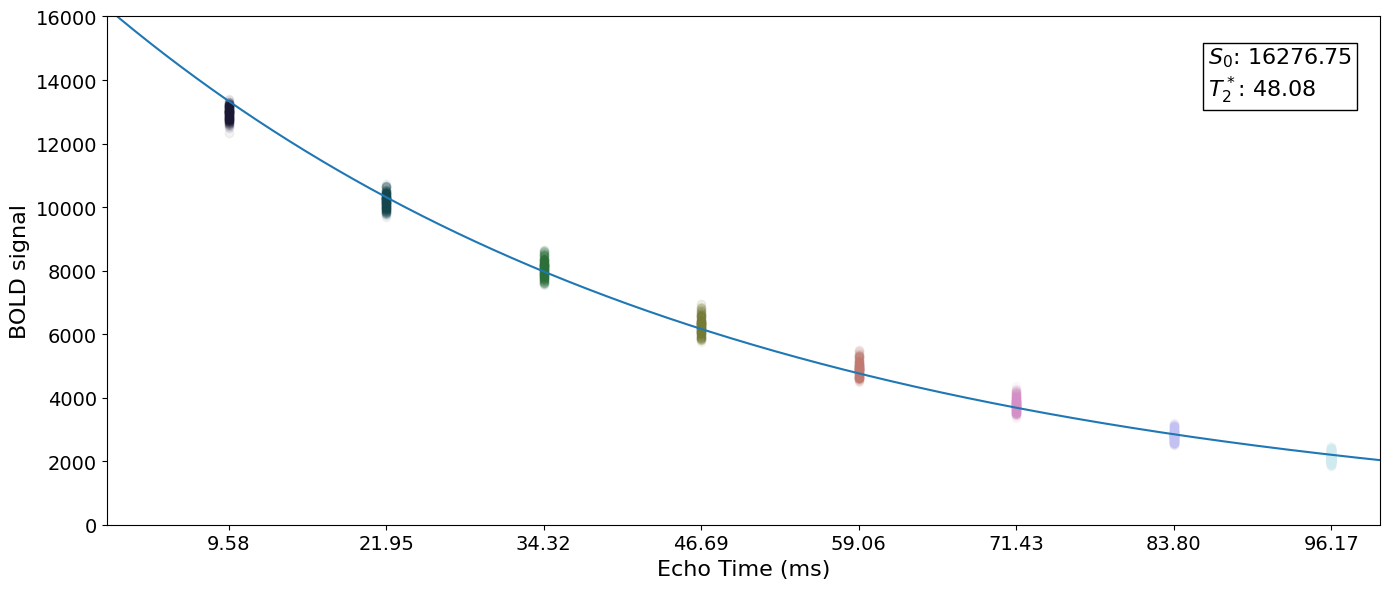

In [11]:
fig, ax = plt.subplots(figsize=(14, 6))
for i_echo in range(n_echoes):
    rep_echo_times = np.ones(n_trs) * echo_times[i_echo]
    ax.scatter(rep_echo_times, ts[i_echo], alpha=0.05, color=pal[i_echo])

ax.plot(mono_x, mono_y)

ax.set_ylabel('BOLD signal', fontsize=16)
ax.set_xlabel('Echo Time (ms)', fontsize=16)
ax.set_xticks(echo_times)
ax.set_xlim(0, 100)
ax.set_ylim(0, 16000)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.annotate('$S_0$: {0:.02f}\n$T_2^*$: {1:.02f}'.format(s0, t2s),
            xy=(86.5, 13500), fontsize=16,
            bbox=dict(fc="white", ec="black", lw=1))

fig.tight_layout()
fig.savefig(op.join(OUT_DIR, 'a06_monoexponential_decay_model.png'), dpi=400)

## T2*

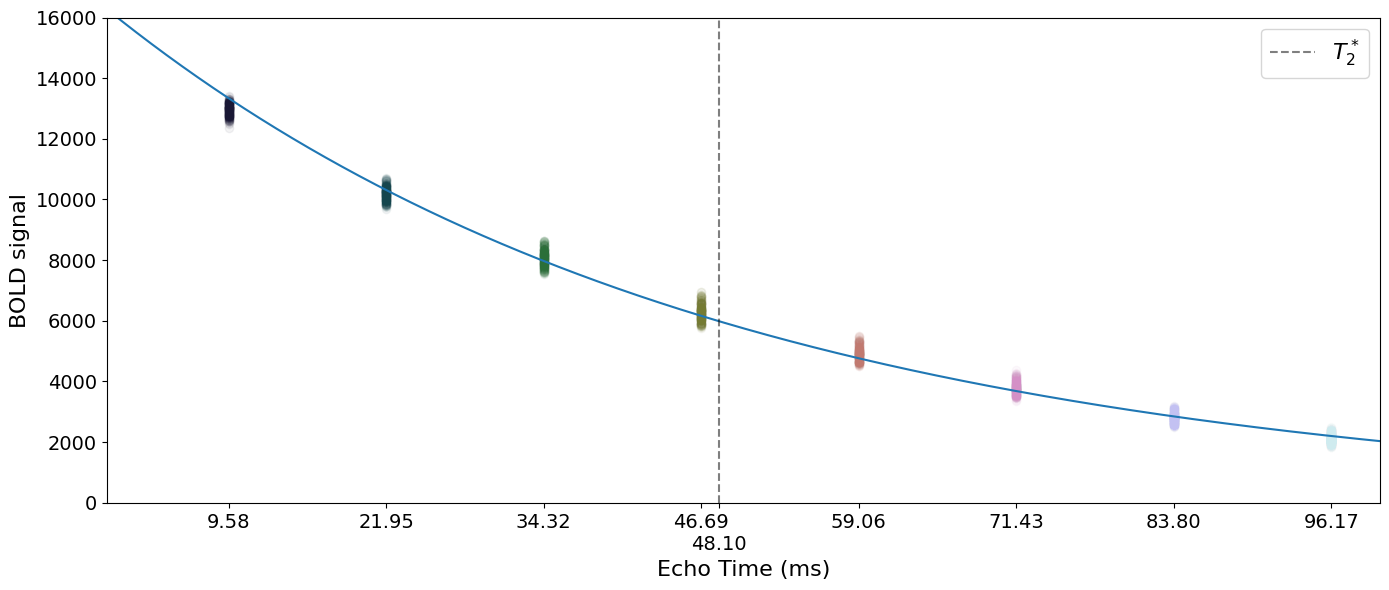

In [12]:
fig, ax = plt.subplots(figsize=(14, 6))
for i_echo in range(n_echoes):
    rep_echo_times = np.ones(n_trs) * echo_times[i_echo]
    ax.scatter(rep_echo_times, ts[i_echo], alpha=0.05, color=pal[i_echo])

ax.plot(mono_x, mono_y)

ax.axvline(t2s, 0, 1, label='$T_2^*$', color='black', linestyle='--', alpha=0.5)
ax.set_ylabel('BOLD signal', fontsize=16)
ax.set_xlabel('Echo Time (ms)', fontsize=16)
ax.set_xticks(np.hstack((echo_times, [np.round(t2s, 1)])))
ax.set_xlim(0, 100)
ax.set_ylim(0, 16000)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.xaxis.get_major_ticks()[-1].set_pad(20)

legend = ax.legend(frameon=True, fontsize=16)

fig.tight_layout()
fig.savefig(op.join(OUT_DIR, 'a07_monoexponential_decay_model_with_t2.png'), dpi=400)

## Optimal combination weights

/var/folders/ph/w3cbhj9n16s9bx4l7gq3dq6m0000gn/T/ipykernel_17156/2100136600.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=echo_times, y=alpha, ax=ax, palette=pal)


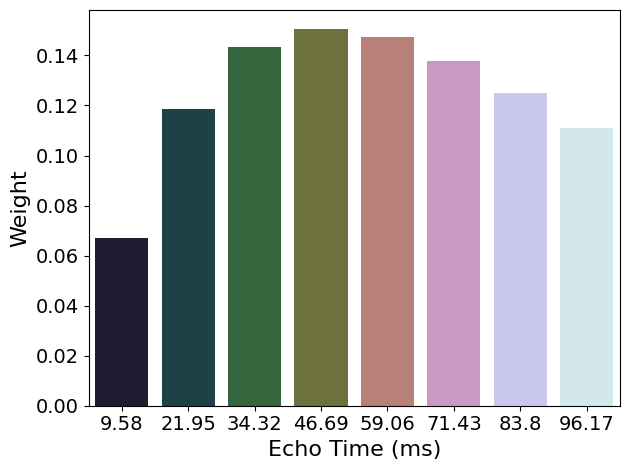

In [13]:
fig, ax = plt.subplots()
sns.barplot(x=echo_times, y=alpha, ax=ax, palette=pal)
ax.set_ylabel('Weight', fontsize=16)
ax.set_xlabel('Echo Time (ms)', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
fig.tight_layout()
fig.savefig(op.join(OUT_DIR, 'a08_optimal_combination_echo_weights.png'), dpi=400)

## Optimally combined timeseries

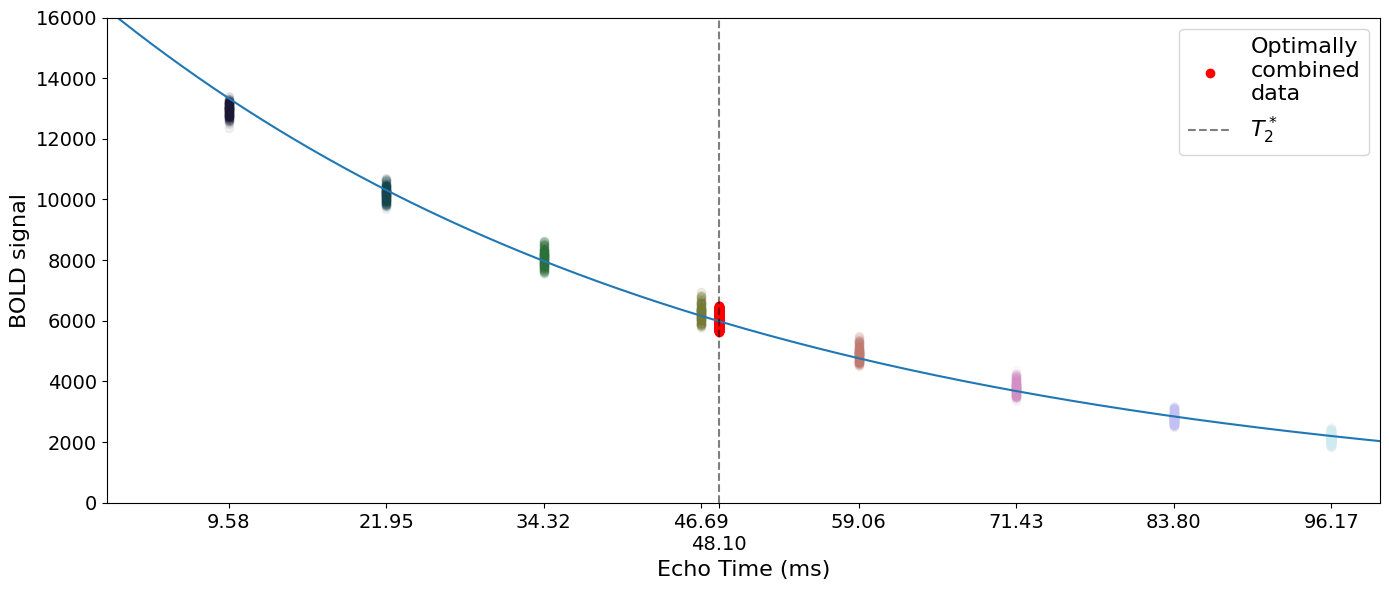

In [14]:
fig, ax = plt.subplots(figsize=(14, 6))
for i_echo in range(n_echoes):
    rep_echo_times = np.ones(n_trs) * echo_times[i_echo]
    ax.scatter(rep_echo_times, ts[i_echo], alpha=0.05, color=pal[i_echo])

ax.plot(mono_x, mono_y)

# Optimal combination
rep_t2s = np.ones(n_trs) * t2s
ax.scatter(rep_t2s, oc_manual, alpha=1, color='red', label='Optimally\ncombined\ndata')

ax.axvline(t2s, 0, 20000, label='$T_2^*$', color='black', linestyle='--', alpha=0.5)
ax.set_ylabel('BOLD signal', fontsize=16)
ax.set_xlabel('Echo Time (ms)', fontsize=16)
ax.set_xticks(np.hstack((echo_times, [np.round(t2s, 1)])))
ax.set_xlim(0, 100)
ax.set_ylim(0, 16000)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.xaxis.get_major_ticks()[-1].set_pad(20)

legend = ax.legend(frameon=True, fontsize=16)

fig.tight_layout()
fig.savefig(op.join(OUT_DIR, 'a09_optimal_combination_value_distributions.png'), dpi=400)

## Optimally combined timeseries

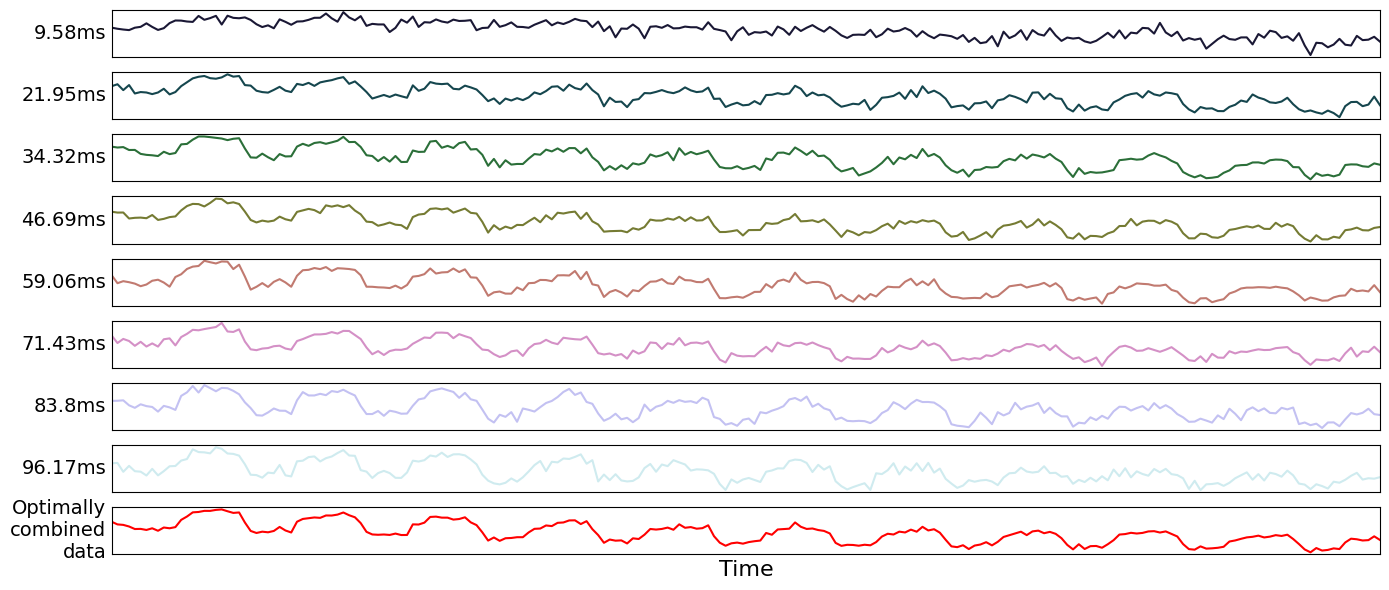

In [15]:
fig, axes = plt.subplots(n_echoes+1, sharex=True, sharey=False, figsize=(14, 6))
for i_echo in range(n_echoes):
    axes[i_echo].plot(ts[i_echo], color=pal[i_echo])
    axes[i_echo].set_ylabel(f'{echo_times[i_echo]}ms', rotation=0, va='center', ha='right', fontsize=14)
    axes[i_echo].set_yticks([])
    axes[i_echo].set_xticks([])

axes[-1].plot(oc_manual, color='red')
axes[-1].set_ylabel('Optimally\ncombined\ndata', rotation=0, va='center', ha='right', fontsize=14)
axes[-1].set_xlabel('Time', fontsize=16)
axes[-1].set_yticks([])
axes[-1].set_xticks([])
axes[-1].set_xlim(0, len(ts[i_echo])-1)
ax.tick_params(axis='both', which='major', labelsize=14)
fig.tight_layout()
fig.savefig(op.join(OUT_DIR, 'a10_optimal_combination_timeseries.png'), dpi=400)

## Global Signal Correction

/var/folders/ph/w3cbhj9n16s9bx4l7gq3dq6m0000gn/T/ipykernel_17156/2968112544.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


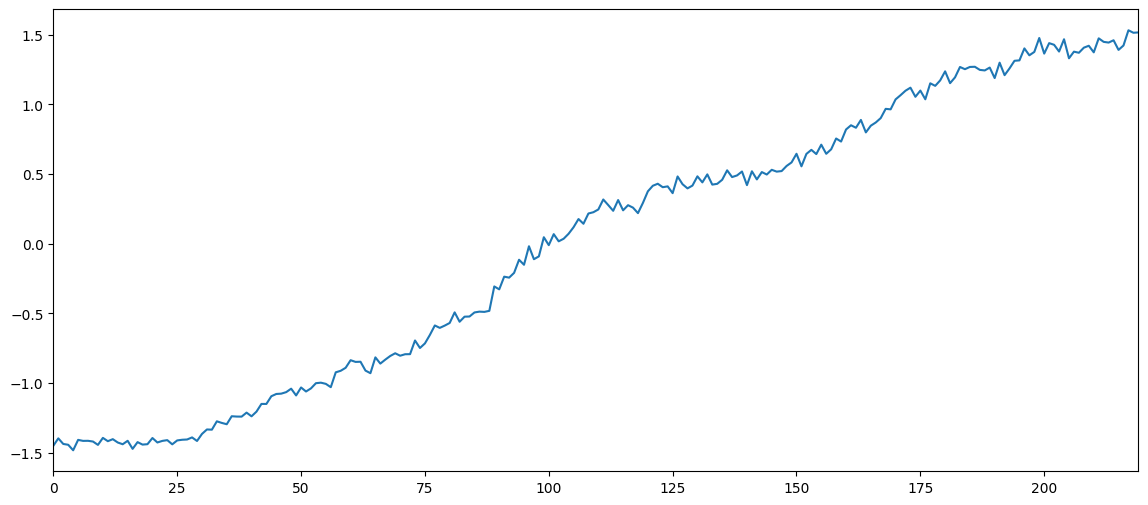

In [16]:
fig, ax = plt.subplots(figsize=(14, 6))
gs = global_signal["global_signal"].values
ax.plot(gs)
ax.set_xlim(0, gs.size - 1)
fig.show()

## Multi-Echo Principal Components Analysis
Optimally combined data are decomposed with PCA.
The PCA components are selected according to one of multiple possible approaches.
Two possible approaches are a decision tree and a threshold using the percentage of variance explained by each component.

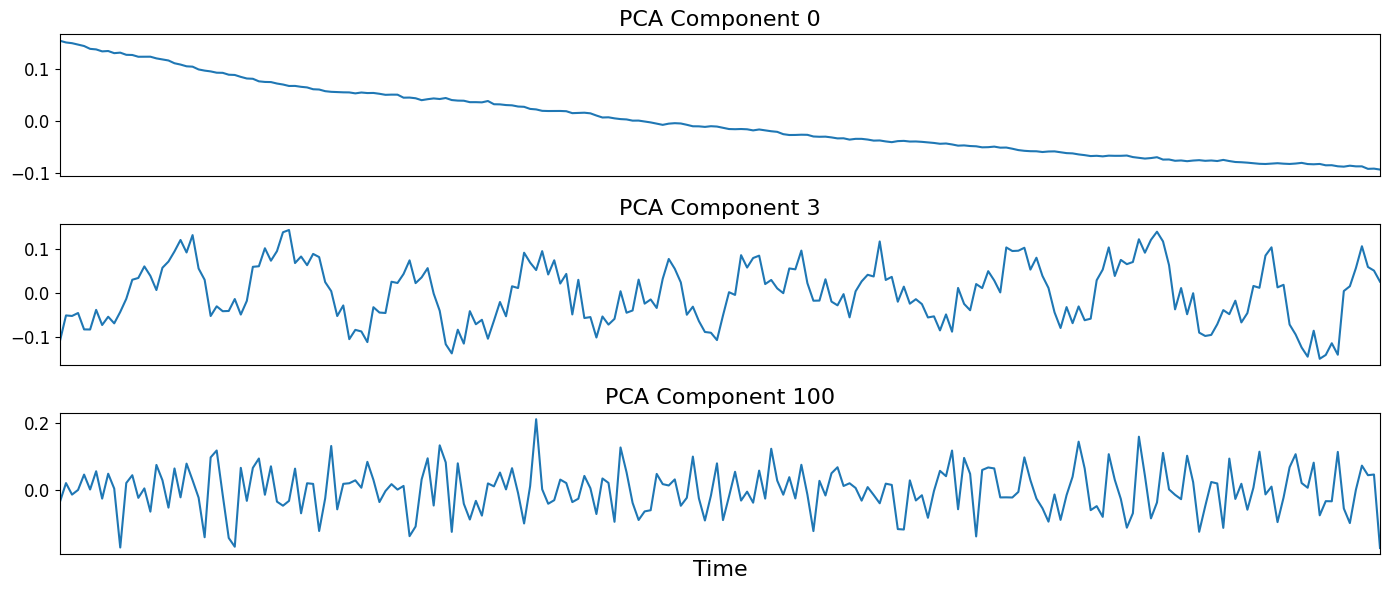

In [17]:
fig, axes = plt.subplots(3, sharex=True, figsize=(14, 6))

i = 0
axes[0].plot(mepca_mmix.values[:, i])
axes[0].set_title(f'PCA Component {i}', fontsize=16)

i = 3
axes[1].plot(mepca_mmix.values[:, i])
axes[1].set_title(f'PCA Component {i}', fontsize=16)

i = 100
axes[2].plot(mepca_mmix.values[:, i])
axes[2].set_title(f'PCA Component {i}', fontsize=16)

axes[2].set_xlim(0, mepca_mmix.shape[0]-1)
axes[2].set_xticks([])
axes[2].set_xlabel('Time', fontsize=16)
axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[1].tick_params(axis='both', which='major', labelsize=12)
axes[2].tick_params(axis='both', which='major', labelsize=12)
fig.tight_layout()
fig.savefig(op.join(OUT_DIR, 'a11_pca_component_timeseries.png'), dpi=400)

# Data Whitening
The selected components from the PCA are recombined to produce a whitened version of the optimally combined data.

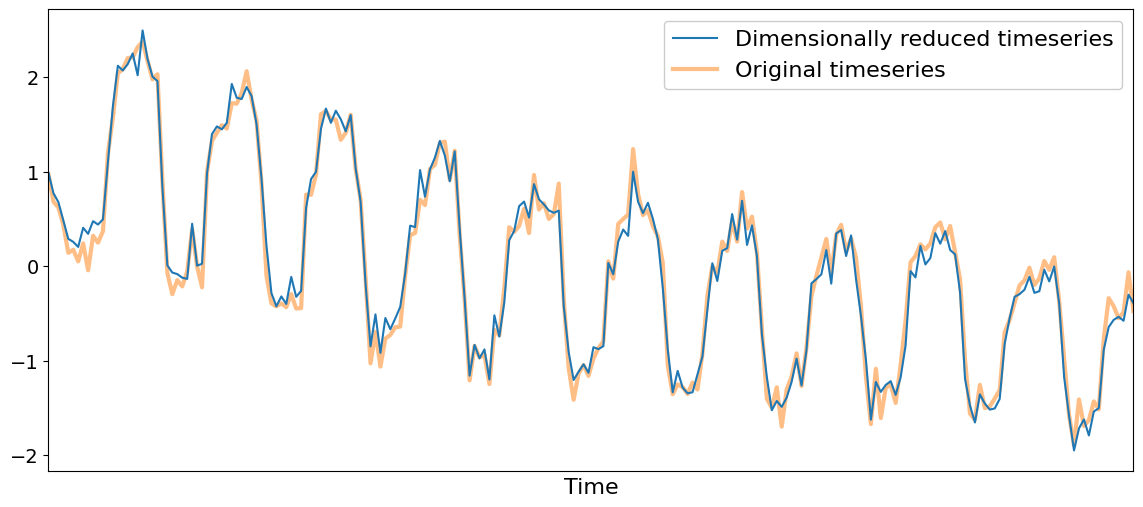

In [18]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(oc_red[:, voxel_idx], label='Dimensionally reduced timeseries', zorder=1.)
ax.plot(oc_z[:, voxel_idx], label='Original timeseries', alpha=0.5, zorder=0., linewidth=3)
legend = ax.legend(frameon=True, fontsize=16, loc='upper right', framealpha=1)
ax.set_xlim(0, oc_z.shape[0]-1)
ax.set_xticks([])
ax.set_xlabel('Time', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
fig.savefig(op.join(OUT_DIR, 'a12_pca_reduced_data.png'), dpi=400)

## Multi-Echo Independent Components Analysis
The whitened optimally combined data are then decomposed with ICA. The number of ICA components is limited to the number of retained components from the PCA, in order to reflect the true dimensionality of the data.
ICA produces a mixing matrix (i.e., timeseries for each component).

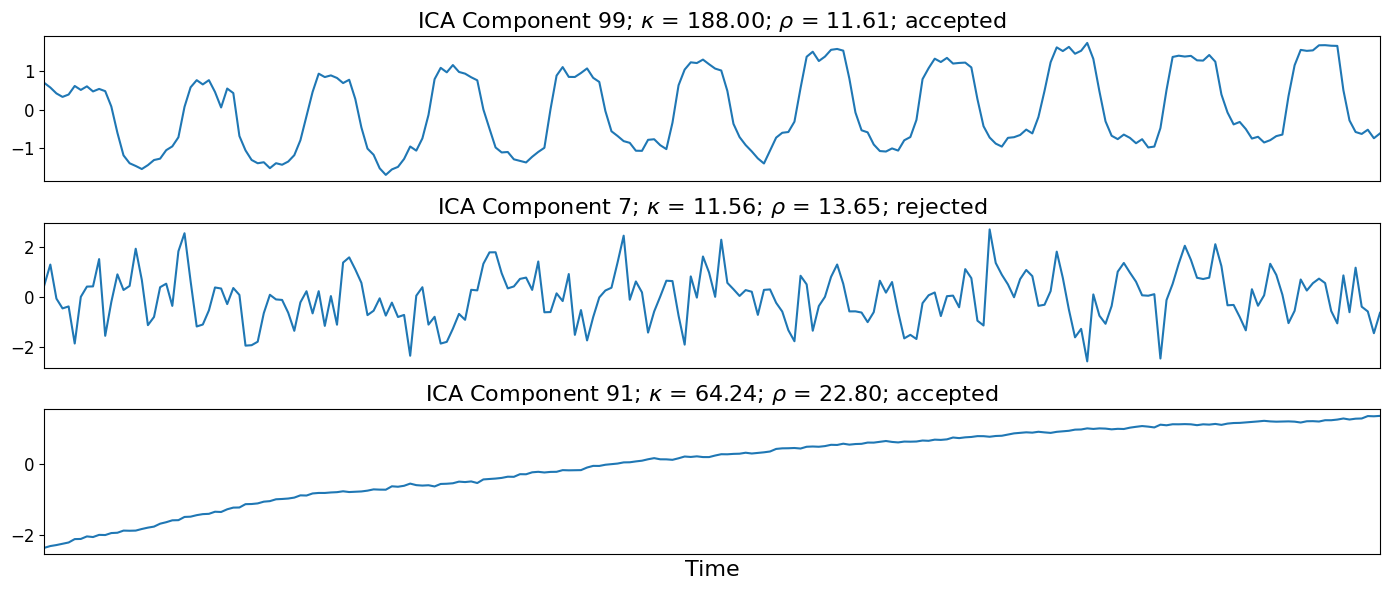

In [19]:
components = []
classifications = []

fig, axes = plt.subplots(3, sharex=True, figsize=(14, 6))
i = df.loc[df["kappa"] == df["kappa"].max()].index.values[0]
k = df.loc[i, 'kappa']
r = df.loc[i, 'rho']
c = df.loc[i, 'classification']
axes[0].plot(meica_mmix[meica_mmix.columns.tolist()[i]].values)
axes[0].set_title('ICA Component {0}; $\\kappa$ = {1:.02f}; $\\rho$ = {2:.02f}; {3}'.format(i, k, r, c), fontsize=16)
components.append(i)
classifications.append(c)

rej_df = df.loc[df["classification"] == "rejected"]
i = rej_df.loc[rej_df["rho"] == rej_df["rho"].max()].index.values[0]
k = df.loc[i, 'kappa']
r = df.loc[i, 'rho']
c = df.loc[i, 'classification']
axes[1].plot(meica_mmix[meica_mmix.columns.tolist()[i]].values)
axes[1].set_title('ICA Component {0}; $\\kappa$ = {1:.02f}; $\\rho$ = {2:.02f}; {3}'.format(i, k, r, c), fontsize=16)
components.append(i)
classifications.append(c)

i = df.loc[df["variance explained"] == df["variance explained"].max()].index.values[0]
k = df.loc[i, 'kappa']
r = df.loc[i, 'rho']
c = df.loc[i, 'classification']
axes[2].plot(meica_mmix[meica_mmix.columns.tolist()[i]].values)
axes[2].set_title('ICA Component {0}; $\\kappa$ = {1:.02f}; $\\rho$ = {2:.02f}; {3}'.format(i, k, r, c), fontsize=16)
components.append(i)
classifications.append(c)

axes[0].set_xlim(0, meica_mmix.shape[0]-1)
axes[2].set_xticks([])
axes[2].set_xlabel('Time', fontsize=16)
axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[1].tick_params(axis='both', which='major', labelsize=12)
axes[2].tick_params(axis='both', which='major', labelsize=12)
fig.tight_layout()
fig.savefig(op.join(OUT_DIR, 'a13_ica_component_timeseries.png'), dpi=400)

# $R_2$ and $S_0$ Model Fit
Linear regression is used to fit the component timeseries to each voxel in each echo from the original, echo-specific data. This results in echo- and voxel-specific betas for each of the components. TE-dependence ($R_2$) and TE-independence ($S_0$) models can then be fit to these betas.

These models allow calculation of F-statistics for the $R_2$ and $S_0$ models (referred to as $\kappa$ and $\rho$, respectively).

Note that the values here are for a single voxel (the highest-weighted one for the component), but $\kappa$ and $\rho$ are averaged across voxels.

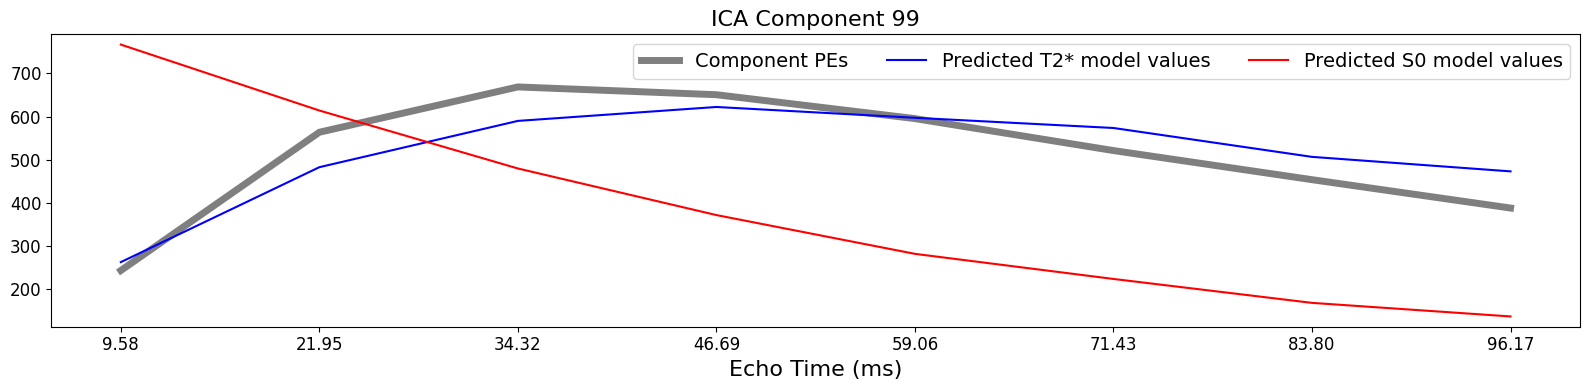

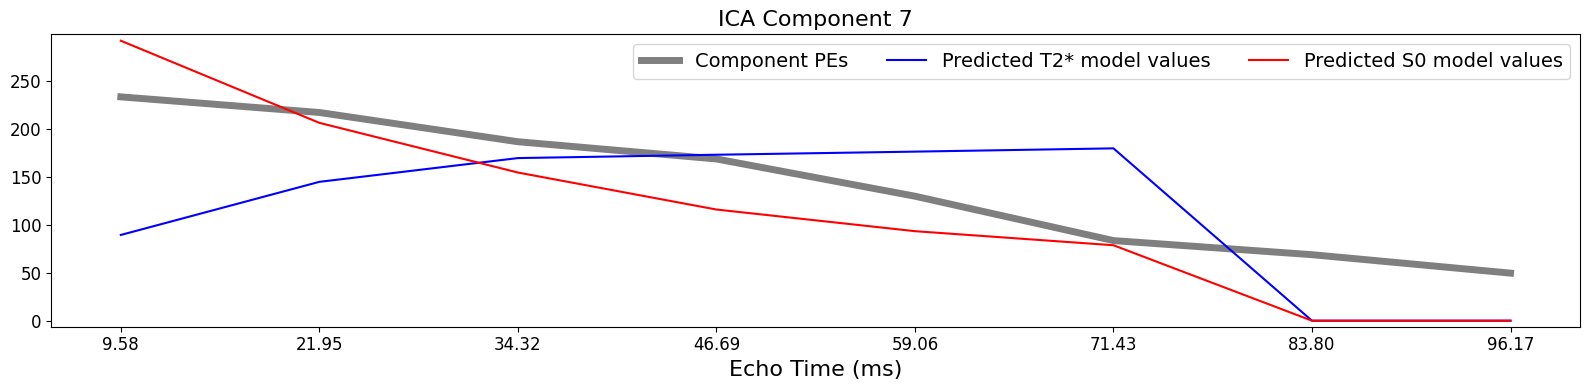

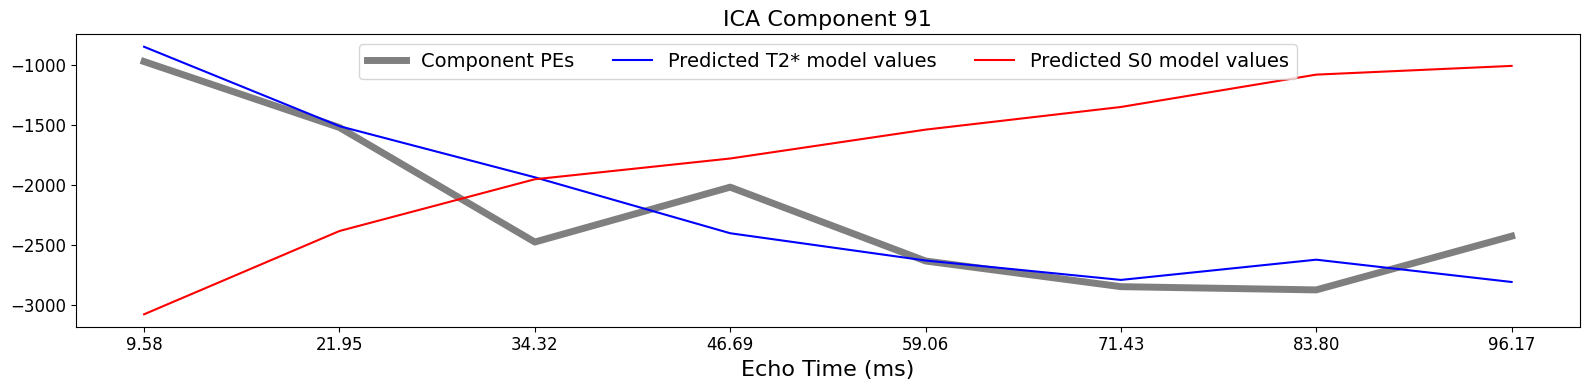

In [20]:
for i, comp in enumerate(components):  # only generate plots for a few components
    classification = classifications[i]
    if classification == "accepted":
        kappa_map = np.abs(meica_kappas[comp, :])
        comp_voxel_idx = np.where(kappa_map == np.max(kappa_map))[0][0]
    else:
        rho_map = np.abs(meica_rhos[comp, :])
        comp_voxel_idx = np.where(rho_map == np.max(rho_map))[0][0]
    
    comp_voxel_idx = np.where(np.abs(beta_maps[comp, :]) == np.max(np.abs(beta_maps[comp, :])))[0][0]

    # Use weight map to average as fitmodels_direct does
    comp_weights = meica_betas[comp, :, comp_voxel_idx]
    r2_pred_weights = r2_pred_betas[comp, :, comp_voxel_idx]
    s0_pred_weights = s0_pred_betas[comp, :, comp_voxel_idx]

    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(echo_times, comp_weights, c='black', alpha=0.5, linewidth=5, label='Component PEs')
    ax.plot(echo_times, r2_pred_weights, c='blue', label='Predicted T2* model values')
    ax.plot(echo_times, s0_pred_weights, c='red', label='Predicted S0 model values')
    ax.set_xticks(echo_times)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xlabel('Echo Time (ms)', fontsize=16)
    temp = np.hstack((comp_weights, s0_pred_weights, r2_pred_weights))
    lim = np.abs(np.mean(temp) * .05)
    ax.set_ylim(np.floor(np.min(temp)) - lim, np.ceil(np.max(temp)) + lim)
    legend = ax.legend(frameon=True, fontsize=14, ncol=3)
    ax.set_title(f'ICA Component {comp}', fontsize=16)
    fig.tight_layout()
    fig.savefig(op.join(OUT_DIR, f'a14_te_dependence_models_component_{i}.png'), dpi=400)

# ICA Component Selection and Multi-Echo Denoising
A decision tree is applied to $\kappa$, $\rho$, and other metrics in order to classify ICA components as TE-dependent (BOLD signal), TE-independent (non-BOLD noise), or neither (to be ignored).

The ICA components are fitted to the original (not whitened) optimally combined data with linear regression, which is used to weight the components for construction of the denoised data. The residuals from this regression will thus include the variance that was not included in the PCA-whitened optimally combined data.

The ME-DN dataset is constructed from the accepted (BOLD) and ignored components, as well as the residual variance not explained by the ICA.
The ME-HK dataset is constructed just from the accepted (BOLD) components. This means that ignored components and residual variance not explained by the ICA are not included in the resulting dataset.

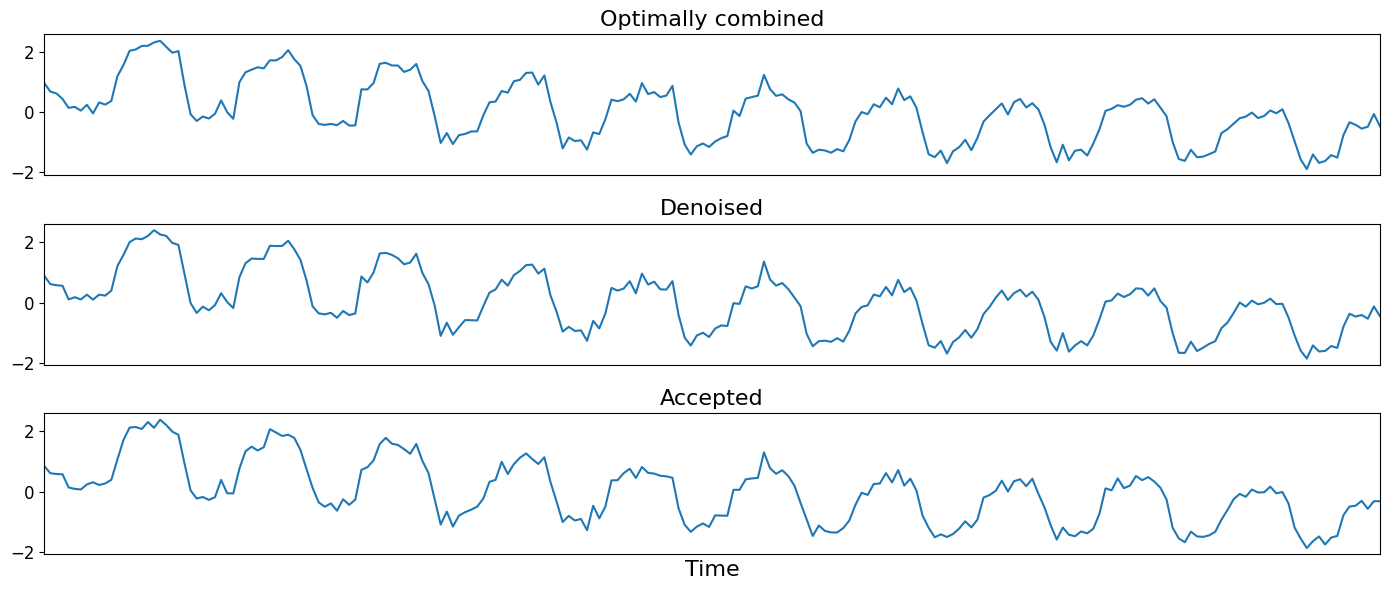

In [21]:
dn_data_z = (dn_data - np.mean(dn_data, axis=0)) / np.std(dn_data, axis=0)
hk_data_z = (hk_data - np.mean(hk_data, axis=0)) / np.std(hk_data, axis=0)

fig, axes = plt.subplots(3, sharex=True, figsize=(14, 6))
axes[0].plot(oc_z[:, voxel_idx], label='Optimally combined')
axes[0].set_title('Optimally combined', fontsize=16)

axes[1].plot(dn_data_z[:, voxel_idx], label='ME-DN')
axes[1].set_title('Denoised', fontsize=16)

axes[2].plot(hk_data_z[:, voxel_idx])
axes[2].set_title('Accepted', fontsize=16)
legend = ax.legend(frameon=True)
axes[0].set_xlim(0, oc_z.shape[0]-1)
axes[2].set_xticks([])
axes[2].set_xlabel('Time', fontsize=16)
axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[1].tick_params(axis='both', which='major', labelsize=12)
axes[2].tick_params(axis='both', which='major', labelsize=12)
fig.tight_layout()

fig.savefig(op.join(OUT_DIR, 'a15_denoised_data_timeseries.png'), dpi=400)

# Post-processing to remove spatially diffuse noise
Due to the constraints of ICA, MEICA is able to identify and remove spatially localized noise components, but it cannot identify components that are spread out throughout the whole brain.

One of several post-processing strategies may be applied to the ME-DN or ME-HK datasets in order to remove spatially diffuse (ostensibly respiration-related) noise. Methods which have been employed in the past include global signal regression (GSR), T1c-GSR, anatomical CompCor, Go Decomposition (GODEC), and robust PCA.

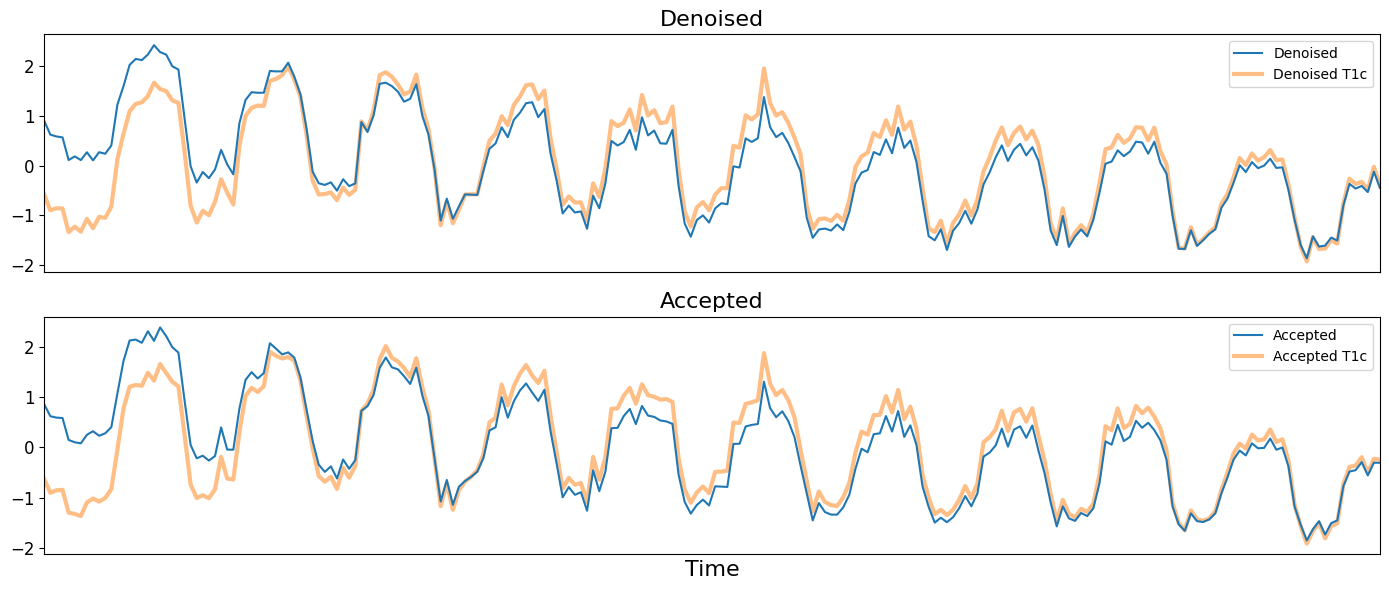

In [22]:
dn_t1c_data_z = (dn_t1c_data - np.mean(dn_t1c_data, axis=0)) / np.std(dn_t1c_data, axis=0)
hk_t1c_data_z = (hk_t1c_data - np.mean(hk_t1c_data, axis=0)) / np.std(hk_t1c_data, axis=0)

fig, axes = plt.subplots(2, sharex=True, figsize=(14, 6))
axes[0].plot(dn_data_z[:, voxel_idx], label='Denoised')
axes[0].plot(dn_t1c_data_z[:, voxel_idx], label='Denoised T1c', alpha=0.5, linewidth=3, zorder=0.)
axes[0].set_title('Denoised', fontsize=16)
legend = axes[0].legend(frameon=True, loc='upper right')

axes[1].plot(hk_data_z[:, voxel_idx], label='Accepted')
axes[1].plot(hk_t1c_data_z[:, voxel_idx], label='Accepted T1c', alpha=0.5, linewidth=3, zorder=0.)
axes[1].set_title('Accepted', fontsize=16)
legend = axes[1].legend(frameon=True)
axes[0].set_xlim(0, oc_z.shape[0]-1)
axes[1].set_xticks([])
axes[1].set_xlabel('Time', fontsize=16)
axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[1].tick_params(axis='both', which='major', labelsize=12)
fig.tight_layout()
fig.savefig(op.join(OUT_DIR, 'a16_t1c_denoised_data_timeseries.png'), dpi=400)